In [1]:
# Copyright 2021 Multiscale Modeling of Fluid Materials, TU Munich
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
!pip install matplotlib

In [3]:
import numpy as onp

import jax.numpy as jnp

from jax import random

import matplotlib.pyplot as plt

from jax.scipy.stats import norm

from numpyro import sample as npy_smpl
import numpyro.infer as npy_inf
import numpyro.distributions as npy_dist

from scipy.stats import gaussian_kde


from jax_sgmc import potential
from jax_sgmc import data
from jax_sgmc import alias

Linear Regression
=========================

This is a toy example with artificial reference data.

Problem
---------

$$ y_i \sim \mathcal{N}\left(\sum_{j=1}^N w_jx_i, \sigma^2\right),\ i = 1, \ldots, 4$$

Reference Data
---------------

$$ u_{1, i}, u_{2, i}, u_{3,i}, u_{4, i} \sim \mathcal{U}\left(-1, 1 \right)$$

The independent variables are uniformly distributed and the first two and last
two pairs are correlated.

$$ x_i = \left(\begin{array}{c} u_{i,1} + u_{2,i} \\ u_{2,i} \\ 0.1u_{3,i} -0.5u_{4,i} \\ u_{4,i} \end{array} \right)$$

The correct solution $w$ is uniformly distributed

$$ \boldsymbol{w} \sim \mathcal{U}\left(-1, 1\right) $$

In [4]:
N = 4
samples = 1000 # Total samples
sigma = 0.5

key = random.PRNGKey(0)
split1, split2, split3 = random.split(key, 3)

w = random.uniform(split3, minval=-1, maxval=1, shape=(N, 1))
noise = sigma * random.normal(split2, shape=(samples, 1))
x = random.uniform(split1, minval=-10, maxval=10, shape=(samples, N))
x = jnp.stack([x[:, 0] + x[:, 1], x[:, 1], 0.1 * x[:, 2] - 0.5 * x[:, 3],
               x[:, 3]]).transpose()
y = jnp.matmul(x, w) + noise


Solution with numpyro
----------------------

In [5]:
def numpyro_model(y_obs=None):
  sigma = npy_smpl("sigma", npy_dist.Uniform(low=0.0, high=10.0))
  weights = npy_smpl("weights",
                     npy_dist.Uniform(low=-10 * jnp.ones((N, 1)),
                                      high=10 * jnp.ones((N, 1))))

  y_pred = jnp.matmul(x, weights)
  npy_smpl("likelihood", npy_dist.Normal(loc=y_pred, scale=sigma), obs=y_obs)

# Collect 1000 samples

kernel = npy_inf.HMC(numpyro_model)
mcmc = npy_inf.MCMC(kernel, num_warmup=1000, num_samples=1000, progress_bar=False)
mcmc.run(random.PRNGKey(0), y_obs=y)
mcmc.print_summary()

w_npy = mcmc.get_samples()["weights"]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       sigma      0.50      0.01      0.50      0.48      0.52     28.96      1.01
weights[0,0]      0.09      0.00      0.09      0.09      0.10    733.81      1.00
weights[1,0]     -0.49      0.00     -0.49     -0.50     -0.48   2671.99      1.00
weights[2,0]     -0.18      0.03     -0.18     -0.22     -0.13     74.85      1.00
weights[3,0]     -0.65      0.01     -0.65     -0.67     -0.62     69.71      1.00

Number of divergences: 0


Solution with Jax SGMC
-----------------------

Reference Data
_______________

The reference data and the desired batch shape must be load into a data loader.
We set the mini-batch for the stochastic gradient evaluation to $M = 10$ and the
cached batch count to $cs = 1000$.

In [6]:
M = 10
cs = 1000

data_loader = data.NumpyDataLoader(x=x, y=y)

Model
______

Next we have to setup the model and the potential function with a evaluation
strategy. Because the model is not very complex, the evaluation of the potential
for a minibatch of data can be vectorized.

In [7]:
def model(sample, observations):
    weights = sample["w"]
    predictors = observations["x"]
    return jnp.dot(predictors, weights)

def likelihood(sample, observations):
    sigma = sample["sigma"]
    y = observations["y"]
    y_pred = model(sample, observations)
    return norm.logpdf(y - y_pred, scale=sigma)

def prior(sample):
    return 0.0

# If the model is more complex, the strategy can be set to map for sequential
# evaluation and pmap for parallel evaluation.
potential_fn = potential.minibatch_potential(prior=prior,
                                             likelihood=likelihood,
                                             strategy="vmap")

Solver
_______

In addition to the refernce data and the potential function, the solver requires
a schedule determining parameters such as the step size and the temperature.
Moreover, an adaption strategy can be provided for some solvers to perform
stochastic gradient langevin diffusion on a manifold.

Next we set up default Stochastic Gradient Langevin Diffusion (SGLD) and SGLD
using RMSprop-adaption.

In [12]:
# Number of iterations
iterations = 50000

sgld = alias.sgld(potential_fn,
                  data_loader,
                  cache_size=512,
                  batch_size=32,
                  burn_in=2000,
                  accepted_samples=1000,
                  rms_prop=True)

init_sample = {"w": jnp.zeros((N, 1)), "sigma": jnp.array(2.0)}
results = sgld(init_sample, iterations=iterations)[0]["samples"]["variables"]

Results
--------

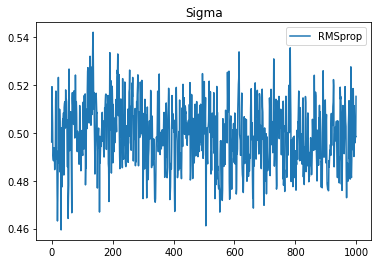

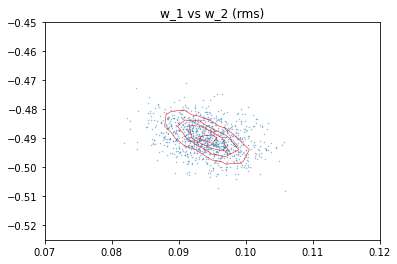

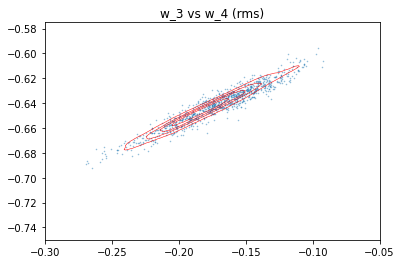

In [13]:
plt.figure()
plt.title("Sigma")

plt.plot(results["sigma"], label="RMSprop")

plt.legend()

w_rms = results["w"]

# Contours of numpyro solution

levels = onp.linspace(0.1, 1.0, 5)

# w1 vs w2
w12 = gaussian_kde(jnp.squeeze(w_npy[:, 0:2].transpose()))
w1d = onp.linspace(0.00, 0.20, 100)
w2d = onp.linspace(-0.70, -0.30, 100)
W1d, W2d = onp.meshgrid(w1d, w2d)
p12d = onp.vstack([W1d.ravel(), W2d.ravel()])
Z12d = onp.reshape(w12(p12d).T, W1d.shape)
Z12d /= Z12d.max()

plt.figure()
plt.title("w_1 vs w_2 (rms)")

plt.xlim([0.07, 0.12])
plt.ylim([-0.525, -0.450])
plt.contour(W1d, W2d, Z12d, levels, colors='red', linewidths=0.5)
plt.plot(w_rms[:, 0], w_rms[:, 1], 'o', alpha=0.5, markersize=0.5, zorder=-1)

# w3 vs w4

w34 = gaussian_kde(jnp.squeeze(w_npy[:, 2:4].transpose()))
w3d = onp.linspace(-0.3, -0.05, 100)
w4d = onp.linspace(-0.75, -0.575, 100)
W3d, W4d = onp.meshgrid(w3d, w4d)
p34d = onp.vstack([W3d.ravel(), W4d.ravel()])
Z34d = onp.reshape(w34(p34d).T, W3d.shape)
Z34d /= Z34d.max()

plt.figure()
plt.title("w_3 vs w_4 (rms)")
plt.contour(W3d, W4d, Z34d, levels, colors='red', linewidths=0.5)
plt.plot(w_rms[:, 2], w_rms[:, 3], 'o', alpha=0.5, markersize=0.5, zorder=-1)